# 소프트맥스 회귀(Softmax Regression)

---

### 1. 소프트맥스 회귀의 비용 함수 구현하기

In [18]:
import torch
import torch.nn.functional as F
torch.manual_seed(1)

In [2]:
z = torch.FloatTensor([1, 2, 3])

hypothesis = F.softmax(z, dim=0)
print(hypothesis)

tensor([0.0900, 0.2447, 0.6652])


In [3]:
z = torch.rand(3, 5, requires_grad=True)
hypothesis = F.softmax(z, dim=1)
print(hypothesis)

tensor([[0.2645, 0.1639, 0.1855, 0.2585, 0.1277],
        [0.2430, 0.1624, 0.2322, 0.1930, 0.1694],
        [0.2226, 0.1986, 0.2326, 0.1594, 0.1868]], grad_fn=<SoftmaxBackward>)


In [4]:
y = torch.randint(5, (3,)).long()
print(y)

tensor([0, 2, 1])


In [5]:
# 모든 원소가 0의 값을 가진 3 × 5 텐서 생성
y_one_hot = torch.zeros_like(hypothesis)
print(y)
print( y.unsqueeze(1))
y_one_hot.scatter_(1, y.unsqueeze(1), 1)

tensor([0, 2, 1])
tensor([[0],
        [2],
        [1]])


tensor([[1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.]])

In [6]:
cost = (y_one_hot * -torch.log(hypothesis)).sum(dim=1).mean()
print(cost)

tensor(1.4689, grad_fn=<MeanBackward0>)


##### 1. F.softmax() + torch.log() = F.log_softmax()

In [7]:
print(F.softmax(z, dim=1))
print(torch.log(F.softmax(z, dim=1)))

tensor([[0.2645, 0.1639, 0.1855, 0.2585, 0.1277],
        [0.2430, 0.1624, 0.2322, 0.1930, 0.1694],
        [0.2226, 0.1986, 0.2326, 0.1594, 0.1868]], grad_fn=<SoftmaxBackward>)
tensor([[-1.3301, -1.8084, -1.6846, -1.3530, -2.0584],
        [-1.4147, -1.8174, -1.4602, -1.6450, -1.7758],
        [-1.5025, -1.6165, -1.4586, -1.8360, -1.6776]], grad_fn=<LogBackward>)


##### 2. F.log_softmax() + F.nll_loss() = F.cross_entropy()

In [8]:
F.nll_loss(F.log_softmax(z, dim=1), y)

tensor(1.4689, grad_fn=<NllLossBackward>)

---

### 2.소프트맥스 회귀 구현하기

##### low-level로 구현 하기

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

x_train = [[1, 2, 1, 1],
           [2, 1, 3, 2],
           [3, 1, 3, 4],
           [4, 1, 5, 5],
           [1, 7, 5, 5],
           [1, 2, 5, 6],
           [1, 6, 6, 6],
           [1, 7, 7, 7]]
y_train = [2, 2, 2, 1, 1, 1, 0, 0]
x_train = torch.FloatTensor(x_train)
y_train = torch.LongTensor(y_train)

In [10]:
print(x_train.shape)
print(y_train.shape)

torch.Size([8, 4])
torch.Size([8])


In [11]:
W = torch.zeros((4,3), requires_grad=True)
b = torch.zeros(3, requires_grad=True)

optimizer = optim.SGD([W, b], lr = 1e-5)

In [12]:
y_one_hot = torch.zeros(8, 3)
y_one_hot.scatter_(1, y_train.unsqueeze(1), 1)
print(y_one_hot)

tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.]])


In [13]:
nb_epoch = 2000
for epoch in range(nb_epoch + 1):
    hypothesis = F.softmax(torch.matmul(x_train, W) + b)
    cost = (y_one_hot * -torch.log(hypothesis)).sum(dim=1).mean()
    
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        print('Epoch {:4d}/{} Cost: {:.6f}'.format(
            epoch, nb_epoch, cost.item()
        ))

c:\users\bj_park\anaconda3\envs\nlp_env\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch    0/2000 Cost: 1.098612
Epoch  100/2000 Cost: 1.096614
Epoch  200/2000 Cost: 1.094678
Epoch  300/2000 Cost: 1.092803
Epoch  400/2000 Cost: 1.090986
Epoch  500/2000 Cost: 1.089224
Epoch  600/2000 Cost: 1.087515
Epoch  700/2000 Cost: 1.085857
Epoch  800/2000 Cost: 1.084246
Epoch  900/2000 Cost: 1.082682
Epoch 1000/2000 Cost: 1.081161
Epoch 1100/2000 Cost: 1.079683
Epoch 1200/2000 Cost: 1.078245
Epoch 1300/2000 Cost: 1.076846
Epoch 1400/2000 Cost: 1.075484
Epoch 1500/2000 Cost: 1.074157
Epoch 1600/2000 Cost: 1.072864
Epoch 1700/2000 Cost: 1.071603
Epoch 1800/2000 Cost: 1.070374
Epoch 1900/2000 Cost: 1.069174
Epoch 2000/2000 Cost: 1.068003


##### 하이레벨로 구현하기

In [14]:
# 모델 초기화
W = torch.zeros((4, 3), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
# optimizer 설정
optimizer = optim.SGD([W, b], lr=0.1)

nb_epochs = 1000
for epoch in range(nb_epochs + 1):

    # Cost 계산
    z = x_train.matmul(W) + b
    cost = F.cross_entropy(z, y_train)

    # cost로 H(x) 개선
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    # 100번마다 로그 출력
    if epoch % 100 == 0:
        print('Epoch {:4d}/{} Cost: {:.6f}'.format(
            epoch, nb_epochs, cost.item()
        ))

Epoch    0/1000 Cost: 1.098612
Epoch  100/1000 Cost: 0.761050
Epoch  200/1000 Cost: 0.689991
Epoch  300/1000 Cost: 0.643229
Epoch  400/1000 Cost: 0.604117
Epoch  500/1000 Cost: 0.568255
Epoch  600/1000 Cost: 0.533922
Epoch  700/1000 Cost: 0.500291
Epoch  800/1000 Cost: 0.466908
Epoch  900/1000 Cost: 0.433506
Epoch 1000/1000 Cost: 0.399962


In [15]:
class SoftmaxClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(4, 3))
    def forward(self, x):
        return self.model(x)

In [17]:
softmax_model = SoftmaxClassifier()
optimizer = optim.SGD(softmax_model.parameters(), lr = 1e-2)
nb_epochs = 2000
for epoch in range(nb_epochs+1):
    h = softmax_model.forward(x_train)
    cost = F.cross_entropy(h, y_train)
    
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        print("{:4d}/{}\t cost:{:6f}".format(epoch, nb_epochs, cost))

   0/2000	 cost:2.637636
 100/2000	 cost:0.838871
 200/2000	 cost:0.744711
 300/2000	 cost:0.688315
 400/2000	 cost:0.648866
 500/2000	 cost:0.619034
 600/2000	 cost:0.595352
 700/2000	 cost:0.575894
 800/2000	 cost:0.559476
 900/2000	 cost:0.545329
1000/2000	 cost:0.532923
1100/2000	 cost:0.521886
1200/2000	 cost:0.511944
1300/2000	 cost:0.502897
1400/2000	 cost:0.494588
1500/2000	 cost:0.486900
1600/2000	 cost:0.479737
1700/2000	 cost:0.473024
1800/2000	 cost:0.466702
1900/2000	 cost:0.460721
2000/2000	 cost:0.455040


---

### 3.소프트맥스로 MNIST 데이터 분류하기

784차원의 벡터로 만드는 코드<br/>
(배치 크기 × 1 × 28 × 28)-->(배치 크기 × 784)

In [ ]:
for X, Y in data_loader:
  # 입력 이미지를 [batch_size × 784]의 크기로 reshape
  # 레이블은 원-핫 인코딩
  X = X.view(-1, 28*28)

#### 분류기 구현을 위한 사전 설정

torchvision은 유명한 데이터셋들, 이미 구현되어져 있는 유명한 모델들, 일반적인 이미지 전처리 도구들을 포함하고 있는 패키지입니다. <br/>
아래의 링크는 torchvision에 어떤 데이터셋들(datasets)과 모델들(models) 그리고 어떤 전처리 방법들(transforms)을 제공

In [1]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
import random

In [2]:
USE_CUDA = torch.cuda.is_available() # GPU를 사용가능하면 True, 아니라면 False를 리턴
device = torch.device("cuda" if USE_CUDA else "cpu") # GPU 사용 가능하면 사용하고 아니면 CPU 사용
print("다음 기기로 학습합니다:", device)

다음 기기로 학습합니다: cpu


In [3]:
# for reproducibility
random.seed(777)
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [4]:
# hyperparameters
training_epochs = 15
batch_size = 100

In [5]:
# MNIST dataset
mnist_train = dsets.MNIST(root='MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root='MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

#### MNIST 분류기 구현하기

In [6]:
# dataset loader
data_loader = DataLoader(dataset=mnist_train,
                                          batch_size=batch_size, # 배치 크기는 100
                                          shuffle=True,
                                          drop_last=True)

In [7]:
linear = nn.Linear(28*28, 10, bias = True).to(device)
## .to('cuda') 쿠다 사용하려면

In [8]:
criterion = nn.CrossEntropyLoss().to(device) # 내부적으로 소프트맥스 함수를 포함하고 있음.
optimizer = torch.optim.SGD(linear.parameters(), lr=0.1)

In [9]:
for epoch in range(training_epochs): # 앞서 training_epochs의 값은 15로 지정함.
    avg_cost = 0
    total_batch = len(data_loader)

    for X, Y in data_loader:
        # 배치 크기가 100이므로 아래의 연산에서 X는 (100, 784)의 텐서가 된다.
        X = X.view(-1, 28 * 28).to(device)
        # 레이블은 원-핫 인코딩이 된 상태가 아니라 0 ~ 9의 정수.
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = linear(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))

print('Learning finished')

Epoch: 0001 cost = 0.535468519
Epoch: 0002 cost = 0.359274209
Epoch: 0003 cost = 0.331187546
Epoch: 0004 cost = 0.316578060
Epoch: 0005 cost = 0.307158172
Epoch: 0006 cost = 0.300180733
Epoch: 0007 cost = 0.295130223
Epoch: 0008 cost = 0.290851533
Epoch: 0009 cost = 0.287417054
Epoch: 0010 cost = 0.284379572
Epoch: 0011 cost = 0.281825215
Epoch: 0012 cost = 0.279800713
Epoch: 0013 cost = 0.277809024
Epoch: 0014 cost = 0.276154310
Epoch: 0015 cost = 0.274440855
Learning finished


c:\users\bj_park\anaconda3\envs\nlp_env\lib\site-packages\torchvision\datasets\mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
c:\users\bj_park\anaconda3\envs\nlp_env\lib\site-packages\torchvision\datasets\mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


Accuracy: 0.8863000273704529
Label:  8
Prediction:  3


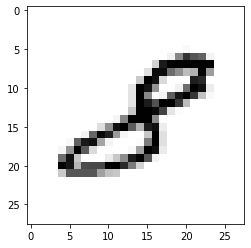

In [10]:
with torch.no_grad(): # torch.no_grad()를 하면 gradient 계산을 수행하지 않는다.
    X_test = mnist_test.test_data.view(-1, 28 * 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)

    prediction = linear(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

    # MNIST 테스트 데이터에서 무작위로 하나를 뽑아서 예측을 해본다
    r = random.randint(0, len(mnist_test) - 1)
    X_single_data = mnist_test.test_data[r:r + 1].view(-1, 28 * 28).float().to(device)
    Y_single_data = mnist_test.test_labels[r:r + 1].to(device)

    print('Label: ', Y_single_data.item())
    single_prediction = linear(X_single_data)
    print('Prediction: ', torch.argmax(single_prediction, 1).item())

    plt.imshow(mnist_test.test_data[r:r + 1].view(28, 28), cmap='Greys', interpolation='nearest')
    plt.show()